## Introduction



This is an example of generation of simulations and projection. We first specify two templates, one
in equ coordinates and `CAR` pixellisation and one in equ coordinates and `HEALPIX` pixellisation. We
generate alms from a `CAMB` lensed power spectrum file and use them to generate a random CMB
realisation in both template. We then project the `HEALPIX` simulation and plot both the native `CAR`
simulation and the projected `HEALPIX` simulation. We chose a low resolution `nside` to emphasize the
effect of resolution



## Preamble



In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pspy, pixell
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("    pixell :", pixell.__version__)
# print("      pspy :", pspy.__version__)

     Numpy : 1.17.4
Matplotlib : 3.1.2
    pixell : 0.6.0+34.g23be32d


Get default data dir from `pspy` and set Planck colormap as default



In [2]:
from pspy.so_config import DEFAULT_DATA_DIR
pixell.colorize.mpl_setdefault("planck")

## Generation of the templates



The `CAR` template will go from right ascension `ra0` to `ra1` and from declination `dec0` to `dec1` (all in
degrees). It will have a resolution of 1 arcminute and it allows 3 components (stokes parameter in
the case of CMB anisotropies).



In [3]:
ra0, ra1 = -5, 5
dec0, dec1 = -5, 5
res = 1
ncomp = 3
from pspy import so_map
template_car = so_map.car_template(ncomp, ra0, ra1, dec0, dec1, res)

We also generate an `HEALPIX` template for which we choose `nside=256` so that the resolution of `HEALPIX`
is much smaller



In [4]:
template_healpix = so_map.healpix_template(ncomp, nside=256, coordinate="equ")

## Read power spectrum and alm generation



We read a `CAMB` lensed power spectrum



In [5]:
from pixell import powspec
clfile = os.path.join(DEFAULT_DATA_DIR, "bode_almost_wmap5_lmax_1e4_lensedCls.dat")
ps = powspec.read_spectrum(clfile)[:ncomp,:ncomp]

and generate alms from the power spectrum up to `lmax = 5000`



In [6]:
from pixell import curvedsky
lmax = 5000
alms = curvedsky.rand_alm(ps, lmax=lmax)

## Computation of stokes parameters



We compute the stokes parameters from the alms in both templates



In [7]:
from pspy import sph_tools
map_healpix = sph_tools.alm2map(alms, template_healpix)
map_car = sph_tools.alm2map(alms, template_car)

and we project the `HEALPIX` map into the `CAR` template



In [8]:
map_healpix_proj = so_map.healpix2car(map_healpix, map_car, lmax=lmax)

Preparing SHT
T -> alm
float64 complex128
P -> alm
Projecting


## Showing maps



We plot both the native `CAR` map and the `HEALPIX` projected to `CAR` map. They contain the same CMB but
have different resolutions.



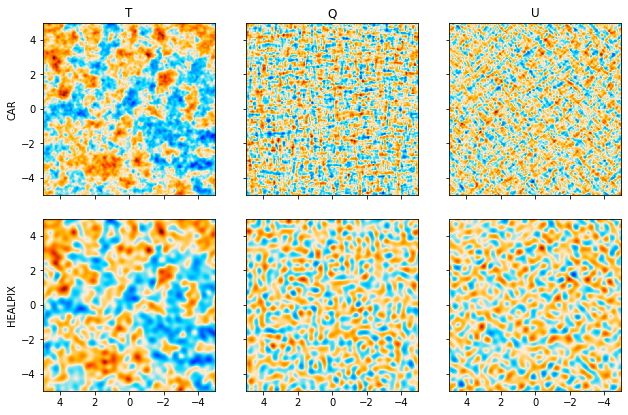

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
fields = ["T", "Q", "U"]
kwargs = dict(extent=[ra1, ra0, dec0, dec1], origin="lower")
for i, field in enumerate(fields):
    kwargs["vmin"] = np.min([map_car.data[i], map_healpix_proj.data[i]])
    kwargs["vmax"] = np.max([map_car.data[i], map_healpix_proj.data[i]])
    axes[0, i].imshow(map_car.data[i], **kwargs)
    axes[1, i].imshow(map_healpix_proj.data[i], **kwargs)
    axes[0, i].set_title(fields[i])

axes[0, 0].set_ylabel("CAR")
axes[1, 0].set_ylabel("HEALPIX")
plt.tight_layout()

We can also use the `plot` function from `pspy.so_map` and set the output path to get individual images
for each component T, Q, U.



In [10]:
output_dir = "/tmp/example_projection"
os.makedirs(output_dir, exist_ok=True)
map_car.plot(file_name=output_dir + "/map_car")
map_healpix_proj.plot(file_name=output_dir + "/map_healpix")